## Logistic Regression Implementation on (scaled) non-reduced dataset (baseline model)

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
#df_scaled_sample = df_scaled.sample(n=500, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [7]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [8]:
predictions = model.predict(X_test)

Metrics for LR_original:
Accuracy: 0.7422
Weighted F1: 0.7417
Weighted Precision: 0.7425
Weighted Recall: 0.7422
Macro-Averaged Precision: 0.7427
Macro-Averaged Recall: 0.7407
F1: [0.75827608 0.72376874]
Precision: [0.73754557 0.74778761]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.70      0.72      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


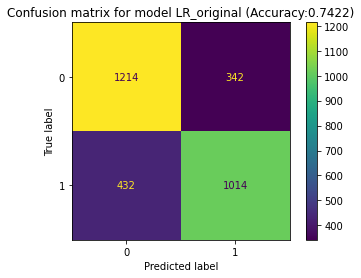

In [9]:
model_metrics = calculate_metrics('LR_original', y_test, predictions)

In [10]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [11]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [12]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7468354430379747


Results of best models Grid Search CV

In [13]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
165  {'C': 100, 'max_iter': 5000, 'penalty': 'l1', ...         0.737443
145  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...         0.737443
161  {'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...         0.737443
149  {'C': 100, 'max_iter': 200, 'penalty': 'l1', '...         0.737443
157  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...         0.737443


Metrics for LR_CV1_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


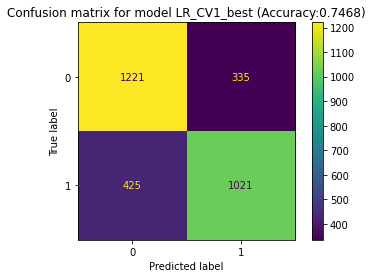

In [14]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy with Stratified K-Fold: 0.7465023317788141


Results of the best model 

In [16]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7465023317788141


Results of best models Grid Search CV

In [17]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
124  {'C': 10, 'max_iter': 500, 'penalty': 'l1', 's...         0.737693
128  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...         0.737693
136  {'C': 10, 'max_iter': 5000, 'penalty': 'l1', '...         0.737693
149  {'C': 100, 'max_iter': 200, 'penalty': 'l1', '...         0.737693
116  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...         0.737693


Metrics for LR_skf_best:
Accuracy: 0.7465
Weighted F1: 0.7460
Weighted Precision: 0.7468
Weighted Recall: 0.7465
Macro-Averaged Precision: 0.7471
Macro-Averaged Recall: 0.7450
F1: [0.76241024 0.72831132]
Precision: [0.74134791 0.75276753]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


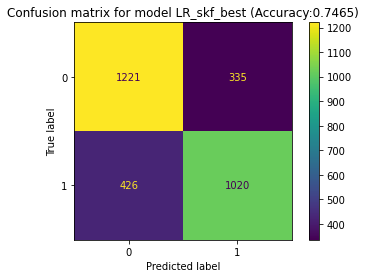

In [18]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [19]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [20]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:04:10,691] A new study created in memory with name: no-name-1d6836f6-9f3c-4b43-96dc-341aeed017f5
[I 2024-06-08 00:04:10,835] Trial 0 finished with value: 0.7438374417055297 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7438374417055297.
[I 2024-06-08 00:04:10,962] Trial 1 finished with value: 0.7425049966688874 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.7438374417055297.
[I 2024-06-08 00:04:11,531] Trial 2 finished with value: 0.7455029980013325 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7455029980013325.
[I 2024-06-08 00:04:11,970] Trial 3 finished with value: 0.7468354430379747 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 3 with value: 0.7468354430379747.
[

Best Hyperparameters: {'penalty': 'l1', 'C': 1.065373030496576, 'max_iter': 963, 'solver': 'saga'}
Best Accuracy: 0.7475016655562958


In [21]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
152,152,0.747502,2024-06-08 00:04:33.723615,2024-06-08 00:04:33.846612,0 days 00:00:00.122997,1.065373,963,l1,saga,COMPLETE
70,70,0.747169,2024-06-08 00:04:21.876762,2024-06-08 00:04:21.997729,0 days 00:00:00.120967,0.819648,681,l1,saga,COMPLETE
156,156,0.747169,2024-06-08 00:04:34.450620,2024-06-08 00:04:34.576579,0 days 00:00:00.125959,1.174918,768,l1,saga,COMPLETE
190,190,0.747169,2024-06-08 00:04:39.473520,2024-06-08 00:04:39.842476,0 days 00:00:00.368956,1.452141,433,l1,liblinear,COMPLETE
68,68,0.747169,2024-06-08 00:04:21.627766,2024-06-08 00:04:21.747763,0 days 00:00:00.119997,0.760989,545,l1,saga,COMPLETE
150,150,0.747169,2024-06-08 00:04:33.169623,2024-06-08 00:04:33.598586,0 days 00:00:00.428963,1.514804,518,l1,liblinear,COMPLETE
118,118,0.747169,2024-06-08 00:04:29.146426,2024-06-08 00:04:29.269443,0 days 00:00:00.123017,0.804828,795,l1,saga,COMPLETE
20,20,0.747169,2024-06-08 00:04:14.191501,2024-06-08 00:04:14.307510,0 days 00:00:00.116009,0.761548,457,l1,saga,COMPLETE
135,135,0.746835,2024-06-08 00:04:31.084619,2024-06-08 00:04:31.515629,0 days 00:00:00.431010,3.845877,133,l1,liblinear,COMPLETE
81,81,0.746835,2024-06-08 00:04:23.284066,2024-06-08 00:04:23.700046,0 days 00:00:00.415980,3.424618,301,l1,liblinear,COMPLETE


Metrics for LR_OPT1_best:
Accuracy: 0.7475
Weighted F1: 0.7469
Weighted Precision: 0.7479
Weighted Recall: 0.7475
Macro-Averaged Precision: 0.7482
Macro-Averaged Recall: 0.7460
F1: [0.76371571 0.72889843]
Precision: [0.74152542 0.75481481]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.79      0.76      1556
     Class 1       0.75      0.70      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


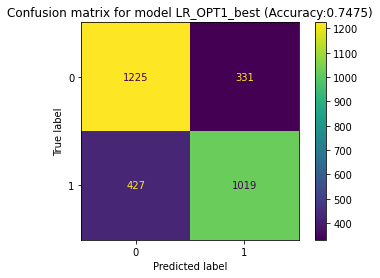

In [22]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT1_best', y_test, predictions_opt1)])

In [23]:
study.best_params

{'penalty': 'l1', 'C': 1.065373030496576, 'max_iter': 963, 'solver': 'saga'}

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
optuna.visualization.plot_parallel_coordinate(study)

In [26]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [27]:
optuna.visualization.plot_param_importances(study)

In [28]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [29]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [30]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:04:44,416] A new study created in memory with name: no-name-6085c7ba-3cd7-447c-856e-14033a8ed678
[I 2024-06-08 00:04:44,575] Trial 0 finished with value: 0.7468354430379747 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:04:44,704] Trial 1 finished with value: 0.7415056628914057 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:04:44,827] Trial 2 finished with value: 0.7411725516322452 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:04:44,956] Trial 3 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7468354430379747


In [31]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.746835,2024-06-08 00:04:44.422704,2024-06-08 00:04:44.575735,0 days 00:00:00.153031,61.355064,0.517298,789,elasticnet,saga,COMPLETE
16,16,0.746835,2024-06-08 00:04:46.600616,2024-06-08 00:04:46.768659,0 days 00:00:00.168043,66.521091,0.483055,912,elasticnet,saga,COMPLETE
113,113,0.746835,2024-06-08 00:05:00.037116,2024-06-08 00:05:00.182165,0 days 00:00:00.145049,95.651405,0.086517,668,elasticnet,saga,COMPLETE
65,65,0.746835,2024-06-08 00:04:53.336906,2024-06-08 00:04:53.475938,0 days 00:00:00.139032,91.867857,0.480687,544,elasticnet,saga,COMPLETE
151,151,0.746835,2024-06-08 00:05:05.151450,2024-06-08 00:05:05.288418,0 days 00:00:00.136968,54.003560,0.857694,548,elasticnet,saga,COMPLETE
46,46,0.746835,2024-06-08 00:04:50.789815,2024-06-08 00:04:50.928776,0 days 00:00:00.138961,1.217760,0.760956,210,elasticnet,saga,COMPLETE
159,159,0.746835,2024-06-08 00:05:06.201450,2024-06-08 00:05:06.333454,0 days 00:00:00.132004,1.416447,0.741395,351,elasticnet,saga,COMPLETE
160,160,0.746835,2024-06-08 00:05:06.334450,2024-06-08 00:05:06.484417,0 days 00:00:00.149967,55.831869,0.524949,826,elasticnet,saga,COMPLETE
42,42,0.746835,2024-06-08 00:04:50.219814,2024-06-08 00:04:50.353810,0 days 00:00:00.133996,22.644087,0.849785,357,elasticnet,saga,COMPLETE
164,164,0.746835,2024-06-08 00:05:06.919115,2024-06-08 00:05:07.075112,0 days 00:00:00.155997,68.568952,0.458114,816,elasticnet,saga,COMPLETE


Metrics for LR_OPT2_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


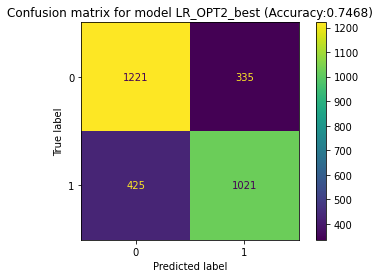

In [32]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT2_best', y_test, predictions_opt2)])

In [33]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [34]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [35]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:05:14,095] A new study created in memory with name: no-name-91293808-9ef2-4647-bbde-b23dfbd23ae9
[I 2024-06-08 00:05:14,239] Trial 0 finished with value: 0.7468354430379747 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:05:14,381] Trial 1 finished with value: 0.7465023317788141 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:05:14,517] Trial 2 finished with value: 0.7465023317788141 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-08 00:05:14,651] Trial 3 finished with value: 0.7418387741505663 and parameters: {'l1_ratio': 0.411

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7468354430379747


In [36]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.746835,2024-06-08 00:05:14.098488,2024-06-08 00:05:14.239522,0 days 00:00:00.141034,94.696791,0.517298,789,elasticnet,saga,COMPLETE
131,131,0.746835,2024-06-08 00:05:33.701534,2024-06-08 00:05:33.844535,0 days 00:00:00.143001,72.450796,0.465636,174,elasticnet,saga,COMPLETE
123,123,0.746835,2024-06-08 00:05:32.486531,2024-06-08 00:05:32.629538,0 days 00:00:00.143007,73.174067,0.633776,971,elasticnet,saga,COMPLETE
122,122,0.746835,2024-06-08 00:05:32.348534,2024-06-08 00:05:32.485532,0 days 00:00:00.136998,81.960295,0.599599,289,elasticnet,saga,COMPLETE
119,119,0.746835,2024-06-08 00:05:31.912545,2024-06-08 00:05:32.051498,0 days 00:00:00.138953,80.787934,0.219515,529,elasticnet,saga,COMPLETE
118,118,0.746835,2024-06-08 00:05:31.766531,2024-06-08 00:05:31.910541,0 days 00:00:00.144010,80.448712,0.227343,414,elasticnet,saga,COMPLETE
116,116,0.746835,2024-06-08 00:05:31.475537,2024-06-08 00:05:31.618512,0 days 00:00:00.142975,87.116476,0.194048,905,elasticnet,saga,COMPLETE
115,115,0.746835,2024-06-08 00:05:31.325535,2024-06-08 00:05:31.473538,0 days 00:00:00.148003,84.407829,0.395236,368,elasticnet,saga,COMPLETE
114,114,0.746835,2024-06-08 00:05:31.184537,2024-06-08 00:05:31.322497,0 days 00:00:00.137960,1.654734,0.794329,207,elasticnet,saga,COMPLETE
113,113,0.746835,2024-06-08 00:05:31.003534,2024-06-08 00:05:31.183532,0 days 00:00:00.179998,99.517332,0.086517,668,elasticnet,saga,COMPLETE


Metrics for LR_OPT3_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


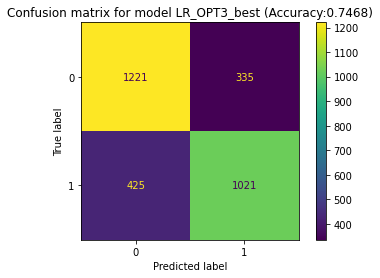

In [37]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT3_best', y_test, predictions_opt3)])

end

In [38]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR_original,0.742172,0.741655,0.742479,0.742172,0.742667,0.740725,[0.75827608 0.72376874],[0.73754557 0.74778761]
LR_CV1_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
LR_skf_best,0.746502,0.745986,0.746848,0.746502,0.747058,0.745049,[0.76241024 0.72831132],[0.74134791 0.75276753]
LR_OPT1_best,0.747502,0.746945,0.747927,0.747502,0.748170,0.745989,[0.76371571 0.72889843],[0.74152542 0.75481481]
LR_OPT2_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
LR_OPT3_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
